In [1]:
# STEP 1: IMPORTS

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


print("All libraries imported successfully!")



All libraries imported successfully!


In [2]:
# STEP 2: UPLOAD CSV FILES (GOOGLE COLAB ONLY)

from google.colab import files

print("Please upload 'nodes.csv'")
uploaded_nodes = files.upload()

print("Please upload 'edges.csv'")
uploaded_edges = files.upload()

# Now read them into DataFrames:
nodes_df = pd.read_csv("nodes.csv")
edges_df = pd.read_csv("edges.csv")

print("NODES DataFrame shape:", nodes_df.shape)
print("EDGES DataFrame shape:", edges_df.shape)

Please upload 'nodes.csv'


Saving nodes.csv to nodes.csv
Please upload 'edges.csv'


Saving edges.csv to edges.csv
NODES DataFrame shape: (3214, 13)
EDGES DataFrame shape: (66771, 8)


In [3]:
# STEP 3: QUICK CHECK

print("First few rows of nodes_df:")
display(nodes_df.head())

print("\nFirst few rows of edges_df:")
display(edges_df.head())

First few rows of nodes_df:


,# index,id,name,city,country,IATA/FAA,ICAO,latitude,longitude,altitude,timezone,DST,_pos
0,0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,"array([6.29268027, 1.37900375])"
1,1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10.0,U,"array([6.30735453, 1.39906658])"
2,2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,"array([6.3014785 , 1.38535133])"
3,3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,"array([6.27849235, 1.39511825])"
4,4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,"array([6.23308524, 1.34013967])"



First few rows of edges_df:


,# source,target,distance,airline,airline_code,codeshare,equipment,stops
0,0,2,124.520121,CG,1308,0,DH8 DHT,0
1,0,3,157.150822,CG,1308,0,DH8,0
2,0,1,106.747399,CG,1308,0,DH8,0
3,0,4,424.726096,CG,1308,0,DH8,0
4,0,4,424.726096,PX,328,0,DH4 DH8 DH3,0


In [4]:
print("Missing values in nodes_df:")
print(nodes_df.isnull().sum())

print("\nMissing values in edges_df:")
print(edges_df.isnull().sum())

Missing values in nodes_df:
# index       0
 id           0
 name         0
 city         0
 country      0
 IATA/FAA     0
 ICAO         0
 latitude     0
 longitude    0
 altitude     0
 timezone     0
 DST          0
 _pos         0
dtype: int64

Missing values in edges_df:
# source          0
 target           0
 distance         0
 airline          0
 airline_code     0
 codeshare        0
 equipment       18
 stops            0
dtype: int64


In [5]:

# CLEAN UP COLUMN NAMES AND RENAME COLUMNS


# 1) Strip, remove '# ', and make lowercase
nodes_df.columns = (
    nodes_df.columns
    .str.strip()
    .str.replace(r"^#\s*", "", regex=True)  # remove leading '# '
    .str.lower()
)
edges_df.columns = (
    edges_df.columns
    .str.strip()
    .str.replace(r"^#\s*", "", regex=True)
    .str.lower()
)

print("NODES columns after cleanup:", nodes_df.columns.to_list())
print("EDGES columns after cleanup:", edges_df.columns.to_list())

# 2) Rename to avoid confusion
#    We want nodes to have 'node_index' (0,1,2,...) if that's how edges reference them
nodes_df.rename(
    columns={
        "index": "node_index",     # e.g. was '# index'
        "id": "openflights_id",    # rename 'id' to something descriptive
        # etc. if you like
    },
    inplace=True
)

# Similarly rename edges columns
edges_df.rename(
    columns={
        "source": "src_index",
        "target": "trg_index",
        # etc. if you like
    },
    inplace=True
)

print("\n=== After renaming ===")
print("NODES DataFrame columns:", nodes_df.columns.to_list())
print("EDGES DataFrame columns:", edges_df.columns.to_list())

# Let's preview the first few rows again
print("\nFirst few rows of nodes_df after rename:")
display(nodes_df.head())

print("\nFirst few rows of edges_df after rename:")
display(edges_df.head())

NODES columns after cleanup: ['index', 'id', 'name', 'city', 'country', 'iata/faa', 'icao', 'latitude', 'longitude', 'altitude', 'timezone', 'dst', '_pos']
EDGES columns after cleanup: ['source', 'target', 'distance', 'airline', 'airline_code', 'codeshare', 'equipment', 'stops']

=== After renaming ===
NODES DataFrame columns: ['node_index', 'openflights_id', 'name', 'city', 'country', 'iata/faa', 'icao', 'latitude', 'longitude', 'altitude', 'timezone', 'dst', '_pos']
EDGES DataFrame columns: ['src_index', 'trg_index', 'distance', 'airline', 'airline_code', 'codeshare', 'equipment', 'stops']

First few rows of nodes_df after rename:


,node_index,openflights_id,name,city,country,iata/faa,icao,latitude,longitude,altitude,timezone,dst,_pos
0,0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,"array([6.29268027, 1.37900375])"
1,1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10.0,U,"array([6.30735453, 1.39906658])"
2,2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,"array([6.3014785 , 1.38535133])"
3,3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,"array([6.27849235, 1.39511825])"
4,4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,"array([6.23308524, 1.34013967])"



First few rows of edges_df after rename:


,src_index,trg_index,distance,airline,airline_code,codeshare,equipment,stops
0,0,2,124.520121,CG,1308,0,DH8 DHT,0
1,0,3,157.150822,CG,1308,0,DH8,0
2,0,1,106.747399,CG,1308,0,DH8,0
3,0,4,424.726096,CG,1308,0,DH8,0
4,0,4,424.726096,PX,328,0,DH4 DH8 DH3,0


In [6]:
G = nx.DiGraph()

# Add nodes WITH ALL ATTRIBUTES
for _, row in nodes_df.iterrows():
    G.add_node(
        row['node_index'],
        name=row['name'],
        country=row['country'],  # <-- ADD THIS
        city=row['city'],        # <-- AND THIS
        latitude=row['latitude'],
        longitude=row['longitude'],
        openflights_id=row['openflights_id']
    )

# Add edges (unchanged)
for _, row in edges_df.iterrows():
    s = row['src_index']
    t = row['trg_index']
    dist = row.get('distance', 0.0)
    if s in G and t in G:
        G.add_edge(s, t, weight=dist)

print("Graph updated with country/city attributes!")
print("Graph has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges.")

Graph updated with country/city attributes!
Graph has 3214 nodes and 36907 edges.


In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === calculating centrality measures ===

# 1) Degree centrality
deg_central = nx.degree_centrality(G)

# 2) Betweenness centrality (weighted by 'distance')
bet_central = nx.betweenness_centrality(G, weight='weight')

# 3) Harmonic centrality (with distance='weight')
harm_central = nx.harmonic_centrality(G, distance='weight')

# 4) Eigenvector centrality
#    Typically done on the largest (weakly) connected component
largest_wcc = max(nx.weakly_connected_components(G), key=len)
subG = G.subgraph(largest_wcc).to_undirected()
eig_sub = nx.eigenvector_centrality_numpy(subG, weight='weight')

# Fill zero for nodes not in largest WCC
eig_central = {}
for n in G.nodes():
    eig_central[n] = eig_sub[n] if n in eig_sub else 0

print("Centralities computed successfully!")

Centralities computed successfully!


In [8]:
#  BUILD A DATAFRAME OF CENTRALITIES & NODE ATTRIBUTES

records = []
for node_id in G.nodes():
    records.append({
        "node_index": node_id,
        "name": G.nodes[node_id]["name"],
        "country": G.nodes[node_id]["country"],  # NOW POPULATED
        "city": G.nodes[node_id]["city"],        # NOW POPULATED
        "latitude": G.nodes[node_id]["latitude"],
        "longitude": G.nodes[node_id]["longitude"],
        "degree": deg_central[node_id],
        "betweenness": bet_central[node_id],
        "harmonic": harm_central[node_id],
        "eigenvector": eig_central[node_id],
    })

df_central = pd.DataFrame(records)
print(f"DataFrame has {df_central.shape[0]} rows (nodes) and {df_central.shape[1]} columns.")
df_central.head()

DataFrame has 3214 rows (nodes) and 10 columns.


,node_index,name,country,city,latitude,longitude,degree,betweenness,harmonic,eigenvector
0,0,Goroka Airport,Papua New Guinea,Goroka,-6.081690,145.391998,0.002490,0.000000,0.372751,0.000019
1,1,Madang Airport,Papua New Guinea,Madang,-5.207080,145.789001,0.004357,0.000006,0.364959,0.000023
2,2,Mount Hagen Kagamuga Airport,Papua New Guinea,Mount Hagen,-5.826790,144.296005,0.005291,0.000010,0.369255,0.000024
3,3,Nadzab Airport,Papua New Guinea,Nadzab,-6.569803,146.725977,0.005602,0.000011,0.369076,0.000015
4,4,Port Moresby Jacksons International Airport,Papua New Guinea,Port Moresby,-9.443380,147.220001,0.019919,0.026251,0.381508,0.011789


In [9]:
#  NORMALIZE CENTRALITIES

measures = ["degree", "betweenness", "harmonic", "eigenvector"]

for m in measures:
    minv = df_central[m].min()
    maxv = df_central[m].max()
    rng = maxv - minv
    if rng > 0:
        df_central[m + "_norm"] = ((df_central[m] - minv) / rng) * 100
    else:
        # In case of a weird scenario where all values are identical:
        df_central[m + "_norm"] = 0
df_central.round(2)
df_central.head()

,node_index,name,country,city,latitude,longitude,degree,betweenness,harmonic,eigenvector,degree_norm,betweenness_norm,harmonic_norm,eigenvector_norm
0,0,Goroka Airport,Papua New Guinea,Goroka,-6.081690,145.391998,0.002490,0.000000,0.372751,0.000019,1.470588,0.000000,33.695770,0.009967
1,1,Madang Airport,Papua New Guinea,Madang,-5.207080,145.789001,0.004357,0.000006,0.364959,0.000023,2.731092,0.009334,32.991376,0.011763
2,2,Mount Hagen Kagamuga Airport,Papua New Guinea,Mount Hagen,-5.826790,144.296005,0.005291,0.000010,0.369255,0.000024,3.361345,0.014730,33.379744,0.012179
3,3,Nadzab Airport,Papua New Guinea,Nadzab,-6.569803,146.725977,0.005602,0.000011,0.369076,0.000015,3.571429,0.016188,33.363578,0.007854
4,4,Port Moresby Jacksons International Airport,Papua New Guinea,Port Moresby,-9.443380,147.220001,0.019919,0.026251,0.381508,0.011789,13.235294,39.509957,34.487360,6.109072


In [10]:
measures = ["degree", "betweenness", "harmonic", "eigenvector"]

for m in measures:
    minv = df_central[m].min()
    maxv = df_central[m].max()
    rng = maxv - minv
    if rng > 0:
        df_central[m + "_norm"] = ((df_central[m] - minv) / rng) * 100
    else:
        df_central[m + "_norm"] = 0

# Round only the normalized columns to 2 decimal places
for m in measures:
    df_central[m + "_norm"] = df_central[m + "_norm"].round(2)

df_central.head()

,node_index,name,country,city,latitude,longitude,degree,betweenness,harmonic,eigenvector,degree_norm,betweenness_norm,harmonic_norm,eigenvector_norm
0,0,Goroka Airport,Papua New Guinea,Goroka,-6.081690,145.391998,0.002490,0.000000,0.372751,0.000019,1.47,0.00,33.70,0.01
1,1,Madang Airport,Papua New Guinea,Madang,-5.207080,145.789001,0.004357,0.000006,0.364959,0.000023,2.73,0.01,32.99,0.01
2,2,Mount Hagen Kagamuga Airport,Papua New Guinea,Mount Hagen,-5.826790,144.296005,0.005291,0.000010,0.369255,0.000024,3.36,0.01,33.38,0.01
3,3,Nadzab Airport,Papua New Guinea,Nadzab,-6.569803,146.725977,0.005602,0.000011,0.369076,0.000015,3.57,0.02,33.36,0.01
4,4,Port Moresby Jacksons International Airport,Papua New Guinea,Port Moresby,-9.443380,147.220001,0.019919,0.026251,0.381508,0.011789,13.24,39.51,34.49,6.11


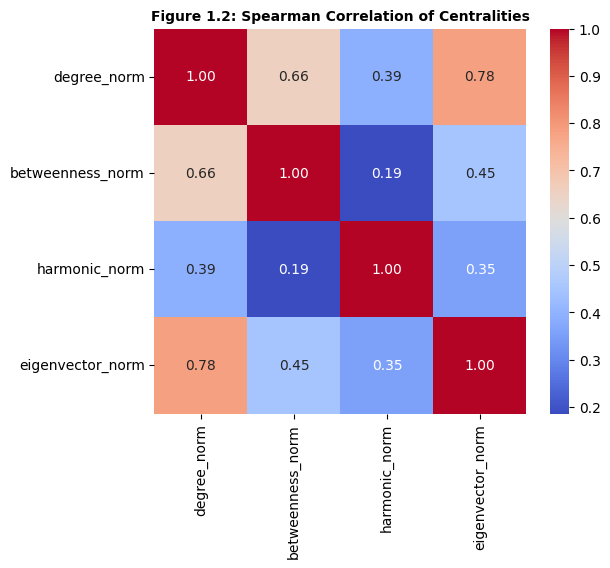

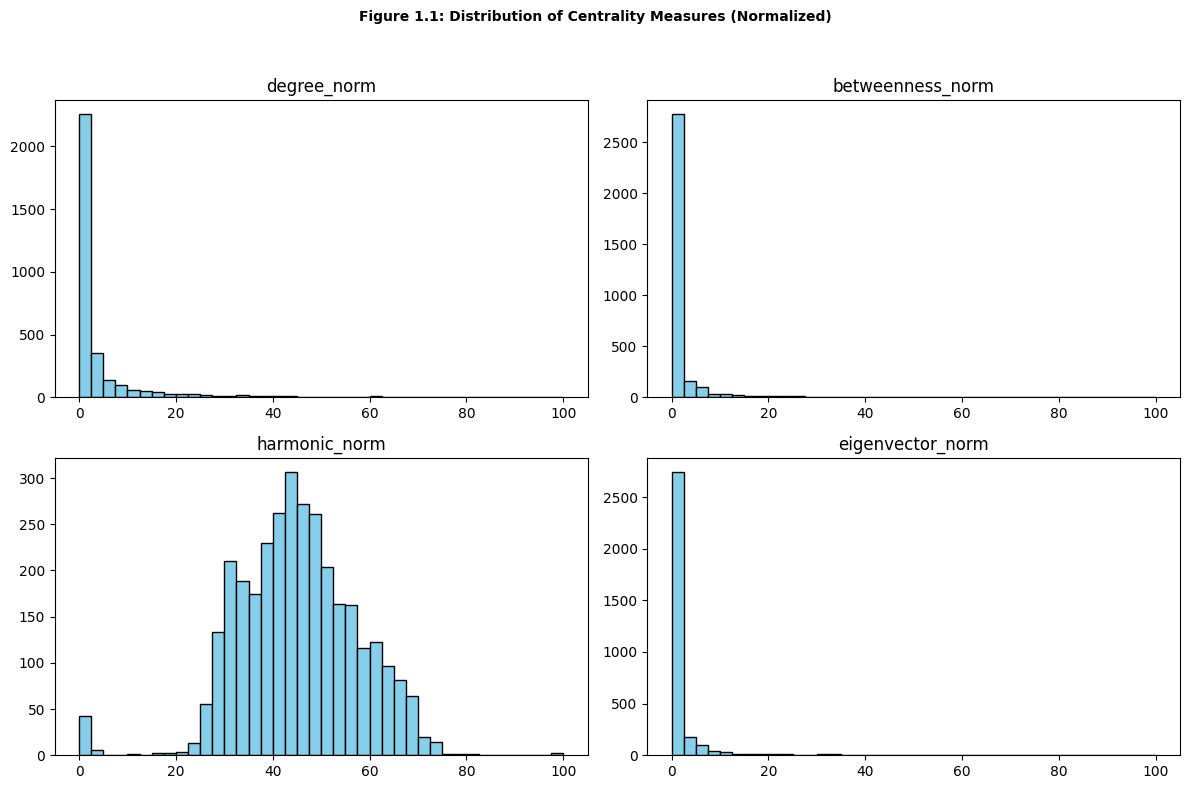

In [11]:
# CORRELATION AND DISTRIBUTIONS

norm_cols = [m+"_norm" for m in measures]
corr_matrix = df_central[norm_cols].corr(method="spearman")

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Figure 1.2: Spearman Correlation of Centralities", fontsize=10, fontweight="bold")
plt.show()

# Histograms
fig, axes = plt.subplots(2,2, figsize=(12,8))
axes = axes.flatten()

for i, mc in enumerate(norm_cols):
    axes[i].hist(df_central[mc], bins=40, color="skyblue", edgecolor="black")
    axes[i].set_title(mc)
fig.suptitle("Figure 1.1: Distribution of Centrality Measures (Normalized)", fontsize=10, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [12]:
#  SHOW TOP 10 LISTS FOR EACH MEASURE

def top_10(df, measure_norm):
    return df.sort_values(by=measure_norm, ascending=False).head(10)[
        ["node_index","name","country","city", measure_norm]
    ]

print("Top 1O by Degree:")
display(top_10(df_central, "degree_norm"))

print("\nTop 10 by Betweenness:")
display(top_10(df_central, "betweenness_norm"))

print("\nTop 10 by Eigenvector:")
display(top_10(df_central, "eigenvector_norm"))

print("\nTop 10 by Harmonic:")
display(top_10(df_central, "harmonic_norm"))

Top 1O by Degree:


,node_index,name,country,city,degree_norm
191,191,Frankfurt am Main Airport,Germany,Frankfurt,100.00
628,628,Charles de Gaulle International Airport,France,Paris,98.53
282,282,Amsterdam Airport Schiphol,Netherlands,Amsterdam,97.06
770,770,Atatürk International Airport,Turkey,Istanbul,94.54
1809,1809,Hartsfield Jackson Atlanta International Airport,United States,Atlanta,90.76
1885,1885,Chicago O'Hare International Airport,United States,Chicago,85.71
1642,1642,Beijing Capital International Airport,China,Beijing,85.50
196,196,Munich Airport,Germany,Munich,79.62
2016,2016,Domodedovo International Airport,Russia,Moscow,78.57
1800,1800,Dallas Fort Worth International Airport,United States,Dallas-Fort Worth,77.94



Top 10 by Betweenness:


,node_index,name,country,city,betweenness_norm
13,13,Keflavik International Airport,Iceland,Keflavik,100.00
1642,1642,Beijing Capital International Airport,China,Beijing,88.47
1754,1754,Seattle Tacoma International Airport,United States,Seattle,87.38
1861,1861,Ted Stevens Anchorage International Airport,United States,Anchorage,80.70
125,125,Lester B. Pearson International Airport,Canada,Toronto,64.88
770,770,Atatürk International Airport,Turkey,Istanbul,64.70
1715,1715,Los Angeles International Airport,United States,Los Angeles,62.71
218,218,Helsinki Vantaa Airport,Finland,Helsinki,62.67
1493,1493,Indira Gandhi International Airport,India,Delhi,55.19
97,97,Vancouver International Airport,Canada,Vancouver,52.18



Top 10 by Eigenvector:


,node_index,name,country,city,eigenvector_norm
191,191,Frankfurt am Main Airport,Germany,Frankfurt,100.00
628,628,Charles de Gaulle International Airport,France,Paris,98.27
1870,1870,John F Kennedy International Airport,United States,New York,97.38
1017,1017,Dubai International Airport,United Arab Emirates,Dubai,97.30
255,255,London Heathrow Airport,United Kingdom,London,93.40
1058,1058,Narita International Airport,Japan,Tokyo,93.05
282,282,Amsterdam Airport Schiphol,Netherlands,Amsterdam,90.98
1642,1642,Beijing Capital International Airport,China,Beijing,89.69
1715,1715,Los Angeles International Airport,United States,Los Angeles,89.23
1943,1943,Incheon International Airport,South Korea,Seoul,85.21



Top 10 by Harmonic:


,node_index,name,country,city,harmonic_norm
2347,2347,Papa Westray Airport,United Kingdom,Papa Westray,100.00
2350,2350,Westray Airport,United Kingdom,Westray,99.68
2349,2349,Sanday Airport,United Kingdom,Sanday,81.01
2348,2348,Stronsay Airport,United Kingdom,Stronsay,79.30
265,265,Kirkwall Airport,United Kingdom,Kirkwall,75.38
191,191,Frankfurt am Main Airport,Germany,Frankfurt,74.83
282,282,Amsterdam Airport Schiphol,Netherlands,Amsterdam,74.45
1854,1854,Philadelphia International Airport,United States,Philadelphia,74.28
196,196,Munich Airport,Germany,Munich,74.19
1885,1885,Chicago O'Hare International Airport,United States,Chicago,73.75


In [13]:
# SHOW TOP 15 LISTS FOR EACH MEASURE

def top_10(df, measure_norm):
    return df.sort_values(by=measure_norm, ascending=False).head(15)[
        ["node_index","name","country","city", measure_norm]
    ]

print("Top 15 by Degree:")
display(top_10(df_central, "degree_norm"))

print("\nTop 15 by Betweenness:")
display(top_10(df_central, "betweenness_norm"))

print("\nTop 15 by Eigenvector:")
display(top_10(df_central, "eigenvector_norm"))

print("\nTop 15 by Harmonic:")
display(top_10(df_central, "harmonic_norm"))

Top 15 by Degree:


,node_index,name,country,city,degree_norm
191,191,Frankfurt am Main Airport,Germany,Frankfurt,100.00
628,628,Charles de Gaulle International Airport,France,Paris,98.53
282,282,Amsterdam Airport Schiphol,Netherlands,Amsterdam,97.06
770,770,Atatürk International Airport,Turkey,Istanbul,94.54
1809,1809,Hartsfield Jackson Atlanta International Airport,United States,Atlanta,90.76
1885,1885,Chicago O'Hare International Airport,United States,Chicago,85.71
1642,1642,Beijing Capital International Airport,China,Beijing,85.50
196,196,Munich Airport,Germany,Munich,79.62
2016,2016,Domodedovo International Airport,Russia,Moscow,78.57
1800,1800,Dallas Fort Worth International Airport,United States,Dallas-Fort Worth,77.94



Top 15 by Betweenness:


,node_index,name,country,city,betweenness_norm
13,13,Keflavik International Airport,Iceland,Keflavik,100.00
1642,1642,Beijing Capital International Airport,China,Beijing,88.47
1754,1754,Seattle Tacoma International Airport,United States,Seattle,87.38
1861,1861,Ted Stevens Anchorage International Airport,United States,Anchorage,80.70
125,125,Lester B. Pearson International Airport,Canada,Toronto,64.88
770,770,Atatürk International Airport,Turkey,Istanbul,64.70
1715,1715,Los Angeles International Airport,United States,Los Angeles,62.71
218,218,Helsinki Vantaa Airport,Finland,Helsinki,62.67
1493,1493,Indira Gandhi International Airport,India,Delhi,55.19
97,97,Vancouver International Airport,Canada,Vancouver,52.18



Top 15 by Eigenvector:


,node_index,name,country,city,eigenvector_norm
191,191,Frankfurt am Main Airport,Germany,Frankfurt,100.00
628,628,Charles de Gaulle International Airport,France,Paris,98.27
1870,1870,John F Kennedy International Airport,United States,New York,97.38
1017,1017,Dubai International Airport,United Arab Emirates,Dubai,97.30
255,255,London Heathrow Airport,United Kingdom,London,93.40
1058,1058,Narita International Airport,Japan,Tokyo,93.05
282,282,Amsterdam Airport Schiphol,Netherlands,Amsterdam,90.98
1642,1642,Beijing Capital International Airport,China,Beijing,89.69
1715,1715,Los Angeles International Airport,United States,Los Angeles,89.23
1943,1943,Incheon International Airport,South Korea,Seoul,85.21



Top 15 by Harmonic:


,node_index,name,country,city,harmonic_norm
2347,2347,Papa Westray Airport,United Kingdom,Papa Westray,100.00
2350,2350,Westray Airport,United Kingdom,Westray,99.68
2349,2349,Sanday Airport,United Kingdom,Sanday,81.01
2348,2348,Stronsay Airport,United Kingdom,Stronsay,79.30
265,265,Kirkwall Airport,United Kingdom,Kirkwall,75.38
191,191,Frankfurt am Main Airport,Germany,Frankfurt,74.83
282,282,Amsterdam Airport Schiphol,Netherlands,Amsterdam,74.45
1854,1854,Philadelphia International Airport,United States,Philadelphia,74.28
196,196,Munich Airport,Germany,Munich,74.19
1885,1885,Chicago O'Hare International Airport,United States,Chicago,73.75


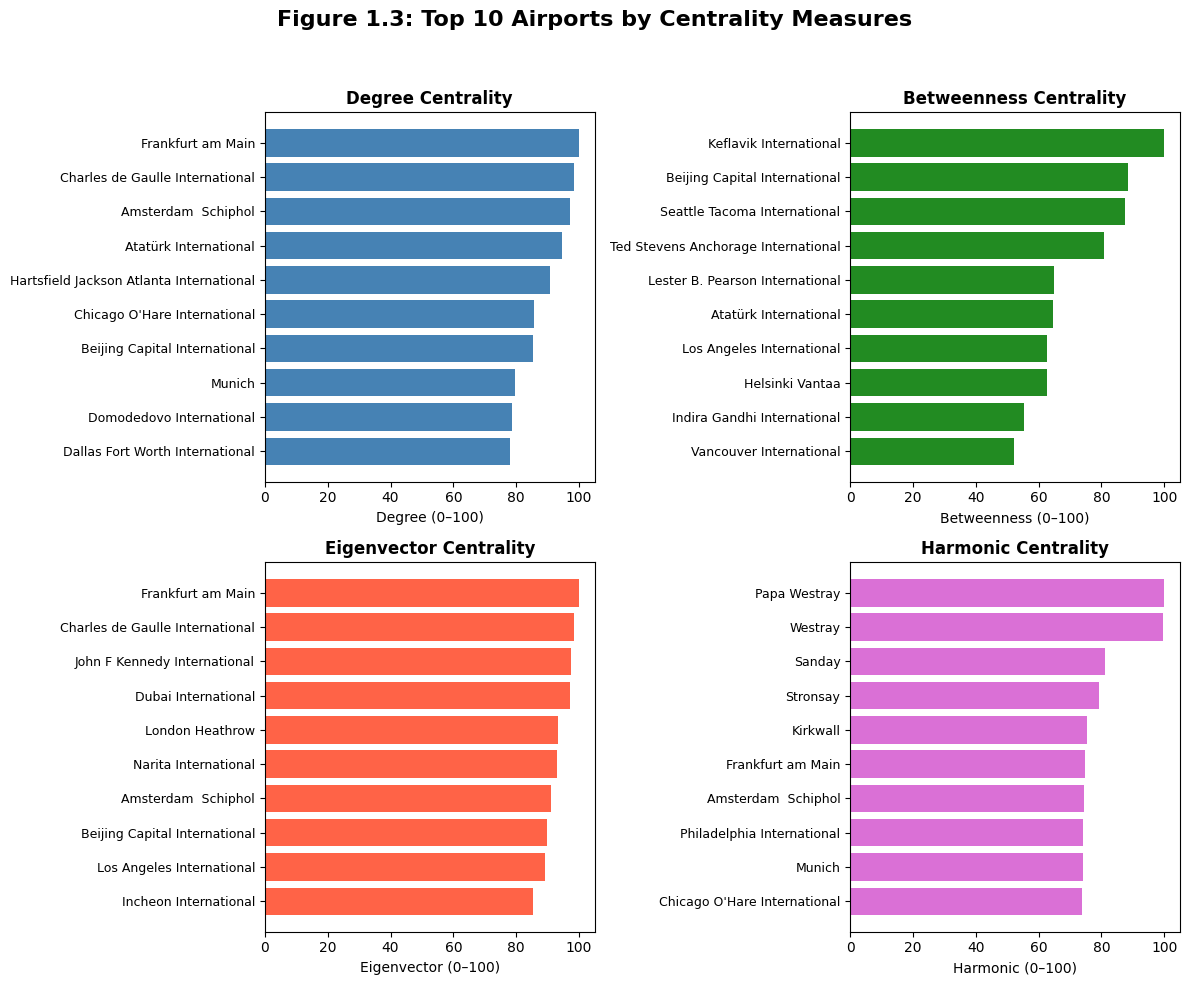

In [16]:
import matplotlib.pyplot as plt

def plot_top_10_bar_charts(df):
    """
    Plots a 2x2 grid of bar charts showing the top 10 airports
    for Degree, Betweenness, Eigenvector, and Harmonic centralities.
    Removes 'Airport' from labels and uses distinct colors for each subplot.
    """

    # Create the 2x2 figure
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Figure 1.3: Top 10 Airports by Centrality Measures", fontsize=16, fontweight="bold")
    # ---------- Subplot 1: Degree Centrality ----------
    top_deg = df.sort_values(by="degree_norm", ascending=False).head(10)
    y_labels_deg = top_deg["name"].str.replace("Airport", "").str.strip()
    axs[0, 0].barh(y_labels_deg, top_deg["degree_norm"], color="steelblue")
    axs[0, 0].invert_yaxis()
    axs[0, 0].set_title("Degree Centrality", fontsize=12, fontweight="bold")
    axs[0, 0].set_xlabel("Degree (0–100)")

    # ---------- Subplot 2: Betweenness Centrality ----------
    top_betw = df.sort_values(by="betweenness_norm", ascending=False).head(10)
    y_labels_betw = top_betw["name"].str.replace("Airport", "").str.strip()
    axs[0, 1].barh(y_labels_betw, top_betw["betweenness_norm"], color="forestgreen")
    axs[0, 1].invert_yaxis()
    axs[0, 1].set_title("Betweenness Centrality", fontsize=12, fontweight="bold")
    axs[0, 1].set_xlabel("Betweenness (0–100)")

    # ---------- Subplot 3: Eigenvector Centrality ----------
    top_eig = df.sort_values(by="eigenvector_norm", ascending=False).head(10)
    y_labels_eig = top_eig["name"].str.replace("Airport", "").str.strip()
    axs[1, 0].barh(y_labels_eig, top_eig["eigenvector_norm"], color="tomato")
    axs[1, 0].invert_yaxis()
    axs[1, 0].set_title("Eigenvector Centrality", fontsize=12, fontweight="bold")
    axs[1, 0].set_xlabel("Eigenvector (0–100)")

    # ---------- Subplot 4: Harmonic Centrality ----------
    top_harm = df.sort_values(by="harmonic_norm", ascending=False).head(10)
    y_labels_harm = top_harm["name"].str.replace("Airport", "").str.strip()
    axs[1, 1].barh(y_labels_harm, top_harm["harmonic_norm"], color="orchid")
    axs[1, 1].invert_yaxis()
    axs[1, 1].set_title("Harmonic Centrality", fontsize=12, fontweight="bold")
    axs[1, 1].set_xlabel("Harmonic (0–100)")

    # Remove default axis labels to free up space & enlarge ticks
    for ax in axs.flat:
        ax.set_ylabel("")
        ax.tick_params(axis='y', labelsize=9)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # allow space for the main title
    plt.show()


plot_top_10_bar_charts(df_central)

In [17]:
!wget -O countries.zip https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
!unzip -o countries.zip -d countries

--2025-02-10 10:09:10--  https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip
Resolving naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)... 52.92.229.73, 52.218.178.11, 52.92.148.241, ...
Connecting to naturalearth.s3.amazonaws.com (naturalearth.s3.amazonaws.com)|52.92.229.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 214976 (210K) [application/zip]
Saving to: ‘countries.zip’

countries.zip       100%[===================>] 209.94K   965KB/s    in 0.2s    

2025-02-10 10:09:11 (965 KB/s) - ‘countries.zip’ saved [214976/214976]

Archive:  countries.zip
  inflating: countries/ne_110m_admin_0_countries.README.html  
 extracting: countries/ne_110m_admin_0_countries.VERSION.txt  
 extracting: countries/ne_110m_admin_0_countries.cpg  
  inflating: countries/ne_110m_admin_0_countries.dbf  
  inflating: countries/ne_110m_admin_0_countries.prj  
  inflating: countries/ne_110m_admin_0_countries.shp  
  inflating: countries/n

In [18]:
!pip install geopandas shapely

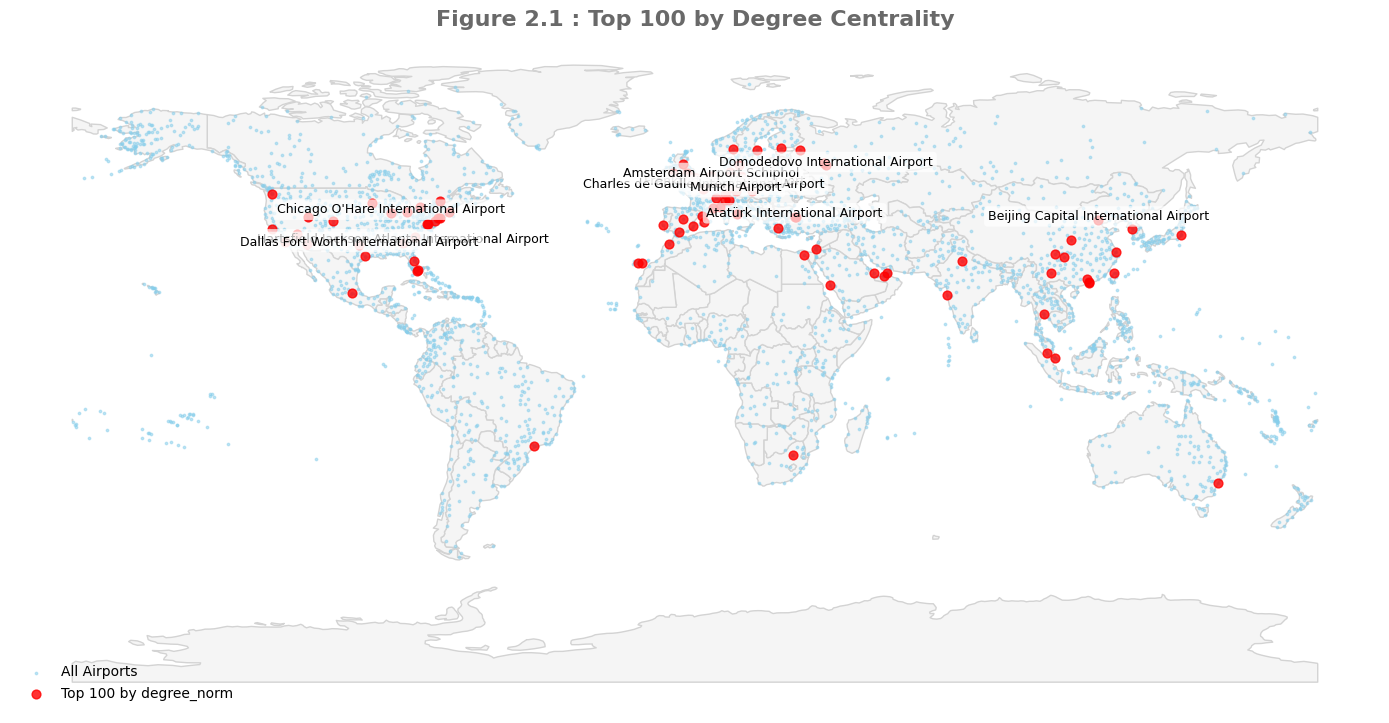

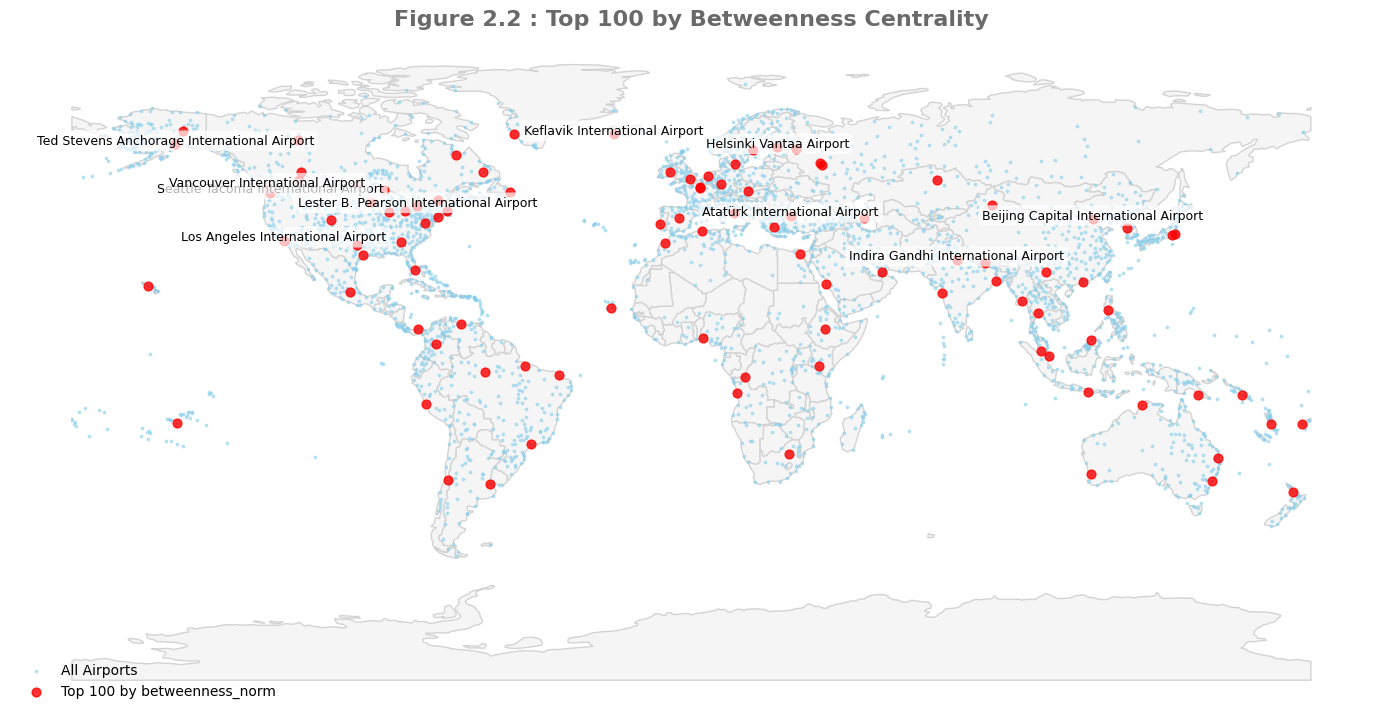

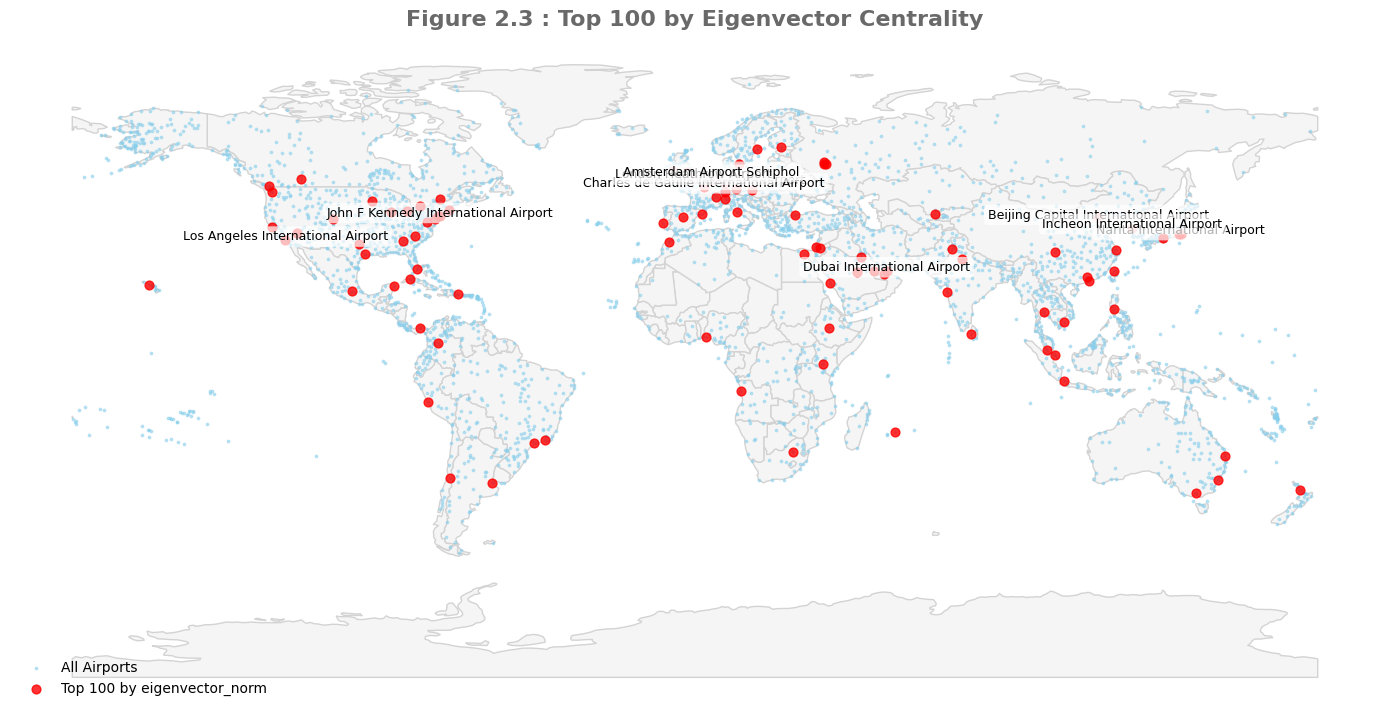

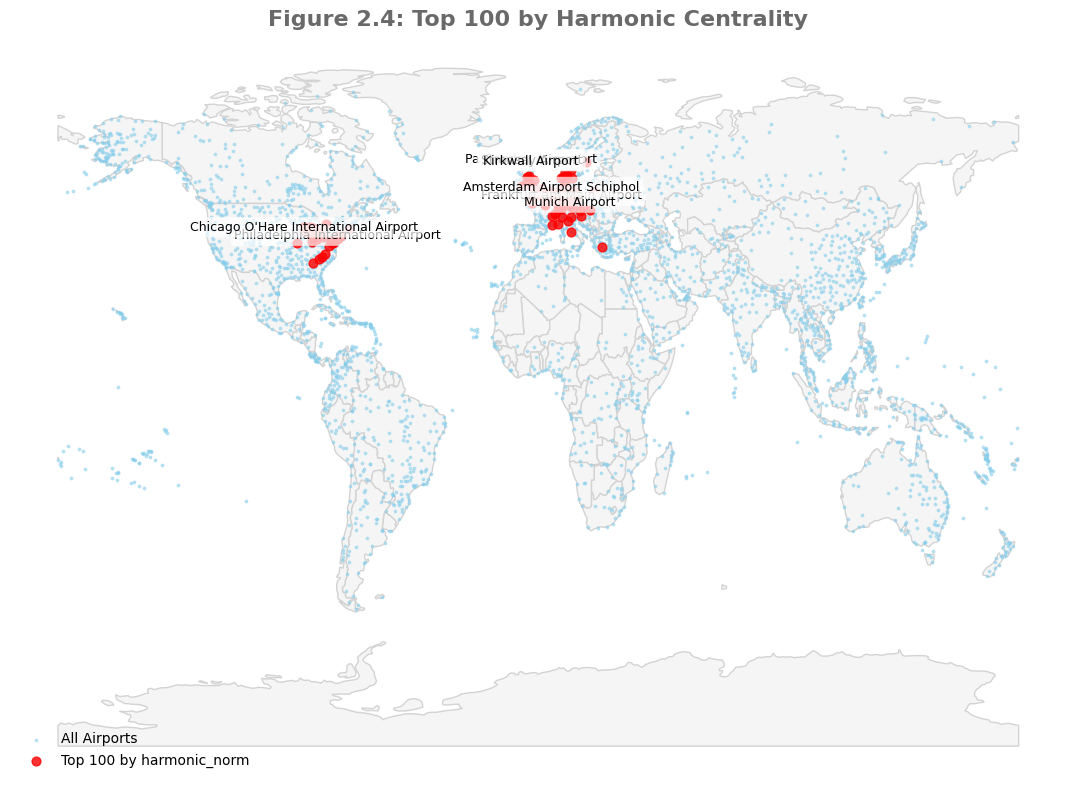

In [19]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

def plot_top_100(df, measure_norm, figure_label="Figure 3.4", title="Top 100 Airports by Centrality"):
    """
    Plots all airports in blue, highlighting the Top 100 (by measure_norm)
    in red on a world map. Also annotates the top 10 airports in red text.
    """
    df_sorted = df.sort_values(by=measure_norm, ascending=False)
    top100 = df_sorted.head(100)
    top10 = df_sorted.head(10)

    # Convert to GeoDataFrames
    geom_all = [Point(xy) for xy in zip(df["longitude"], df["latitude"])]
    gdf_all = gpd.GeoDataFrame(df, geometry=geom_all, crs="EPSG:4326")

    geom_top = [Point(xy) for xy in zip(top100["longitude"], top100["latitude"])]
    gdf_top = gpd.GeoDataFrame(top100, geometry=geom_top, crs="EPSG:4326")

    # Load shapefile (assuming it’s in "countries/" folder)
    world = gpd.read_file("countries/ne_110m_admin_0_countries.shp")

    fig, ax = plt.subplots(figsize=(14, 8))
    world.plot(ax=ax, color="whitesmoke", edgecolor="lightgrey")
    gdf_all.plot(ax=ax, marker="o", color="skyblue", markersize=3, alpha=0.5, label="All Airports")
    gdf_top.plot(ax=ax, marker="o", color="red", markersize=40, alpha=0.8, label=f"Top 100 by {measure_norm}")

    # Annotate top 10
    for _, row in top10.iterrows():
        ax.text(
            row["longitude"], row["latitude"], row["name"],
            fontsize=9, color="black", ha="center",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", boxstyle="round,pad=0.3")
        )

    plt.title(f"{figure_label}: {title}", fontsize=16, fontweight="bold", color="dimgray")
    plt.legend(loc="lower left", fontsize=10, frameon=False)
    plt.axis("off")  # Remove axes for a cleaner map look
    plt.tight_layout()
    plt.show()
# generating 4 different maps, each referencing the same figure number
plot_top_100(df_central, "degree_norm", figure_label="Figure 2.1 ", title="Top 100 by Degree Centrality")
plot_top_100(df_central, "betweenness_norm", figure_label="Figure 2.2 ", title="Top 100 by Betweenness Centrality")
plot_top_100(df_central, "eigenvector_norm", figure_label="Figure 2.3 ", title="Top 100 by Eigenvector Centrality")
plot_top_100(df_central, "harmonic_norm", figure_label="Figure 2.4", title="Top 100 by Harmonic Centrality")

In [20]:
# Define thresholds for high and low centralities
high_threshold = 90  # Top percentile threshold for high centrality
low_threshold = 25   # Low-value threshold for the others

# Identify outliers: High in one measure, strictly low in the others
outliers = df_central[
    ((df_central["betweenness_norm"] > high_threshold) &
     (df_central["degree_norm"] < low_threshold) &
     (df_central["eigenvector_norm"] < low_threshold) &
     (df_central["harmonic_norm"] < low_threshold)) |
    ((df_central["degree_norm"] > high_threshold) &
     (df_central["betweenness_norm"] < low_threshold) &
     (df_central["eigenvector_norm"] < low_threshold) &
     (df_central["harmonic_norm"] < low_threshold)) |
    ((df_central["eigenvector_norm"] > high_threshold) &
     (df_central["degree_norm"] < low_threshold) &
     (df_central["betweenness_norm"] < low_threshold) &
     (df_central["harmonic_norm"] < low_threshold)) |
    ((df_central["harmonic_norm"] > high_threshold) &
     (df_central["degree_norm"] < low_threshold) &
     (df_central["eigenvector_norm"] < low_threshold) &
     (df_central["betweenness_norm"] < low_threshold))
]



In [21]:
# Display the outliers
print("\n=== Outliers: High in One Centrality, Low in Others ===")
display(outliers[["name", "country", "betweenness_norm", "degree_norm", "eigenvector_norm", "harmonic_norm"]])



=== Outliers: High in One Centrality, Low in Others ===


,name,country,betweenness_norm,degree_norm,eigenvector_norm,harmonic_norm
2347,Papa Westray Airport,United Kingdom,0.0,1.05,0.0,100.00
2350,Westray Airport,United Kingdom,0.0,0.63,0.0,99.68


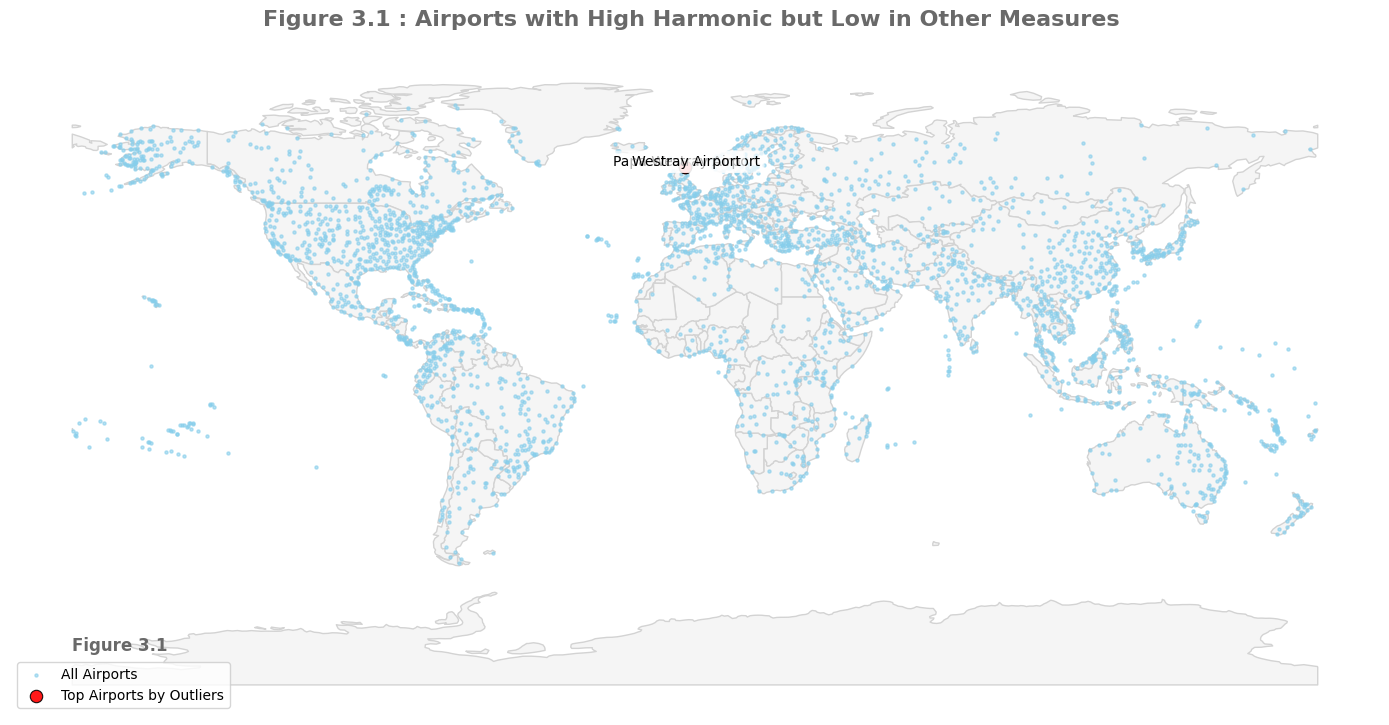

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_outliers_with_figure_name(df, corrected_outliers, centrality_col, title, figure_name):
    # Load world map
    world = gpd.read_file("countries/ne_110m_admin_0_countries.shp")

    # Plot setup
    fig, ax = plt.subplots(figsize=(14, 8))
    world.plot(ax=ax, color="whitesmoke", edgecolor="lightgrey")

    # Plot all airports
    plt.scatter(
        df["longitude"],
        df["latitude"],
        c="skyblue",
        s=5,
        label="All Airports",
        alpha=0.6
    )

    # Highlight corrected outliers
    plt.scatter(
        corrected_outliers["longitude"],
        corrected_outliers["latitude"],
        c="red",
        s=80,  # Increased size for better visibility
        label=f"Top Airports by {centrality_col}",
        edgecolor="black",
        linewidth=0.8,
        alpha=0.9
    )

    # Annotate key airports (corrected outliers)
    for _, row in corrected_outliers.iterrows():
        plt.text(
            row["longitude"] + 0.5,  # Offset longitude slightly for better visibility
            row["latitude"] + 0.5,   # Offset latitude slightly
            row["name"],
            fontsize=10,
            color="black",
            ha="center",
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", boxstyle="round,pad=0.3")
        )

    # Title and legend
    plt.title(title, fontsize=16, fontweight="bold", color="dimgray", pad=20)
    plt.legend(loc="lower left", fontsize=10, frameon=True)

    # Add figure name
    plt.text(
        -180, -80,  # Bottom-left position on the map
        f"Figure {figure_name}",
        fontsize=12,
        color="dimgray",
        fontweight="bold"
    )

    plt.axis("off")
    plt.tight_layout()

    # Show plot
    plt.show()

# Example usage with corrected results
plot_outliers_with_figure_name(
    df_central,  # The full airport dataset
    outliers,  # The corrected outliers DataFrame
    "Outliers",
    "Figure 3.1 : Airports with High Harmonic but Low in Other Measures ",
    "3.1"  # Figure name
)

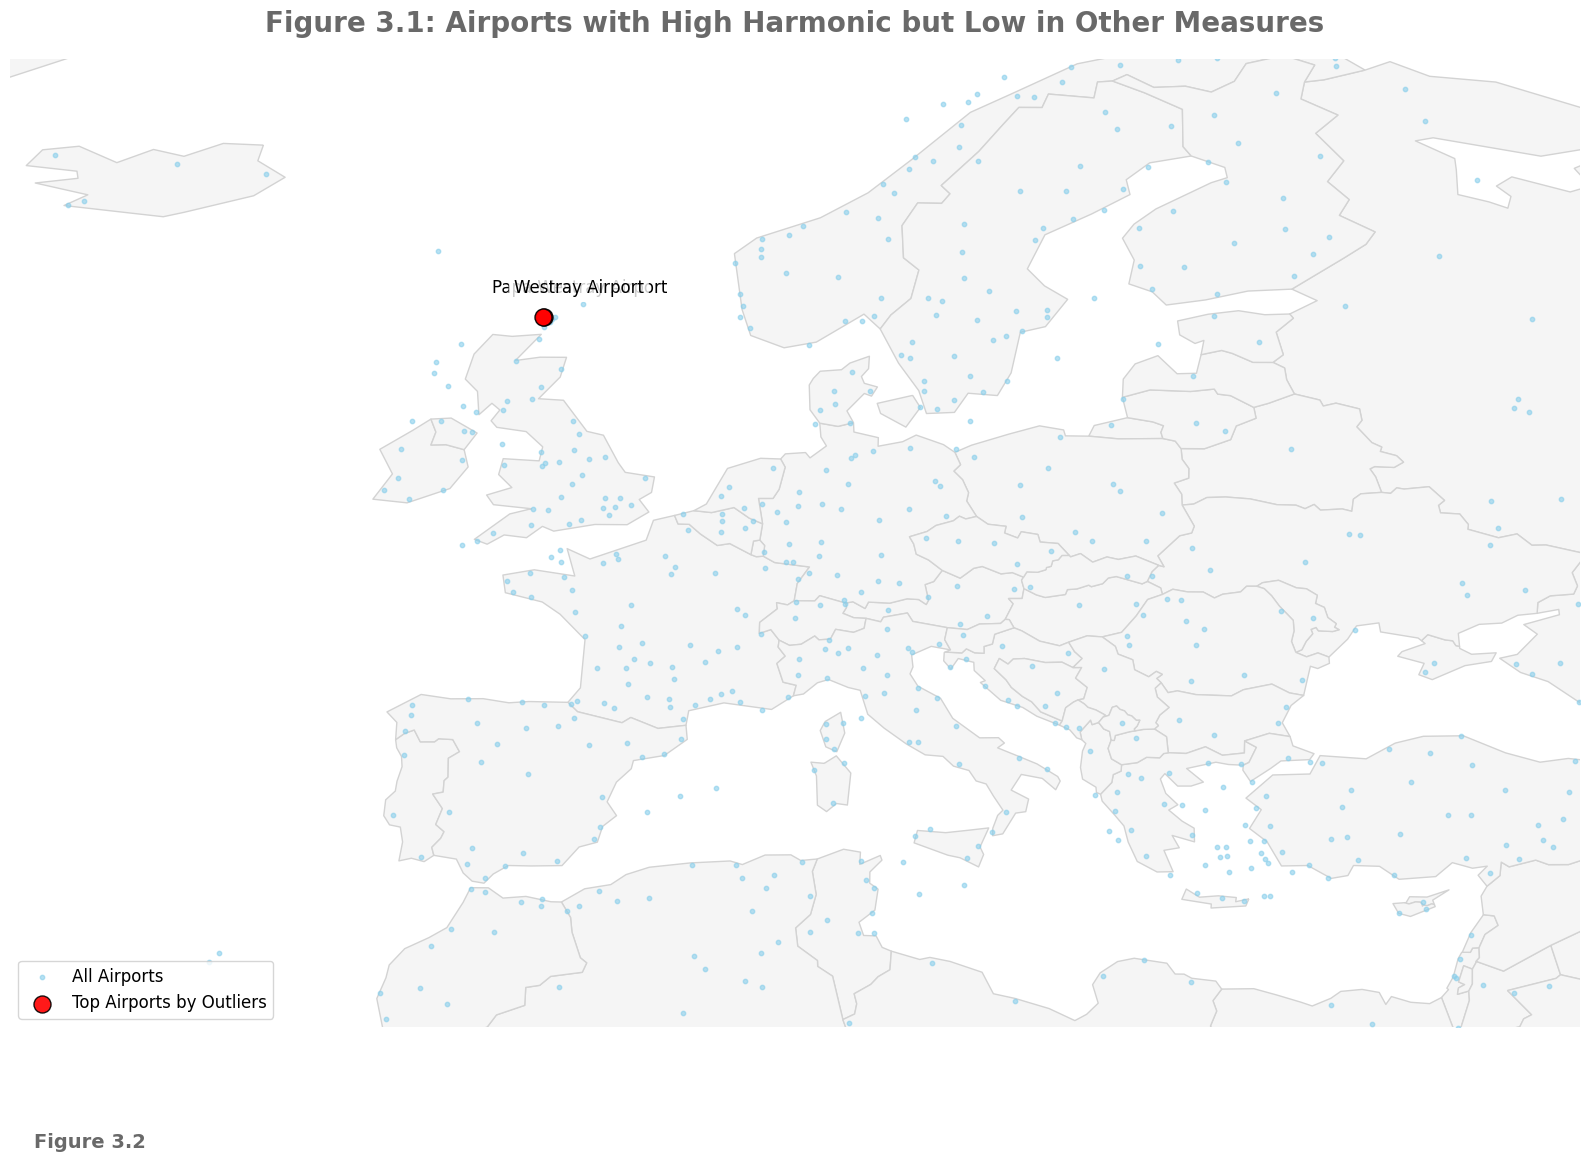

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_outliers_with_zoom_and_offsets(df, corrected_outliers, centrality_col, title, figure_name, zoom_region=None):
    # Load world map
    world = gpd.read_file("countries/ne_110m_admin_0_countries.shp")

    # Plot setup
    fig, ax = plt.subplots(figsize=(16, 12))
    world.plot(ax=ax, color="whitesmoke", edgecolor="lightgrey")

    # Plot all airports
    plt.scatter(
        df["longitude"],
        df["latitude"],
        c="skyblue",
        s=10,
        label="All Airports",
        alpha=0.6
    )

    # Highlight corrected outliers
    plt.scatter(
        corrected_outliers["longitude"],
        corrected_outliers["latitude"],
        c="red",
        s=150,  # Larger size for red dots
        label=f"Top Airports by {centrality_col}",
        edgecolor="black",
        linewidth=1.0,
        alpha=0.9
    )

    # Annotate key airports (corrected outliers) with adjusted offsets
    for i, row in corrected_outliers.iterrows():
        plt.text(
            row["longitude"] + 1.5,  # Adjusted longitude offset
            row["latitude"] + 1.0,  # Adjusted latitude offset
            row["name"],
            fontsize=12,  # Larger text size
            color="black",
            ha="center",
            bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", boxstyle="round,pad=0.3")
        )

    # Title and legend
    plt.title(title, fontsize=20, fontweight="bold", color="dimgray", pad=20)
    plt.legend(loc="lower left", fontsize=12, frameon=True)

    # Add figure name
    plt.text(
        zoom_region["lon_min"] + 1, zoom_region["lat_min"] - 5,  # Position text below the zoomed map
        f"Figure {figure_name}",
        fontsize=14,
        color="dimgray",
        fontweight="bold"
    )

    # Apply zoom region if specified
    if zoom_region:
        plt.xlim(zoom_region["lon_min"], zoom_region["lon_max"])
        plt.ylim(zoom_region["lat_min"], zoom_region["lat_max"])

    plt.axis("off")
    plt.tight_layout()

    # Show plot
    plt.show()

# Example usage: Zooming into Europe
zoom_region = {
    "lon_min": -25,  # Longitude range for Europe
    "lon_max": 40,
    "lat_min": 30,   # Latitude range for Europe
    "lat_max": 70
}

plot_outliers_with_zoom_and_offsets(
    df_central,  # The full airport dataset
    outliers,  # The corrected outliers DataFrame
    "Outliers",
    "Figure 3.1: Airports with High Harmonic but Low in Other Measures",
    "3.2",  # Figure name
    zoom_region  # Apply zoom region
)

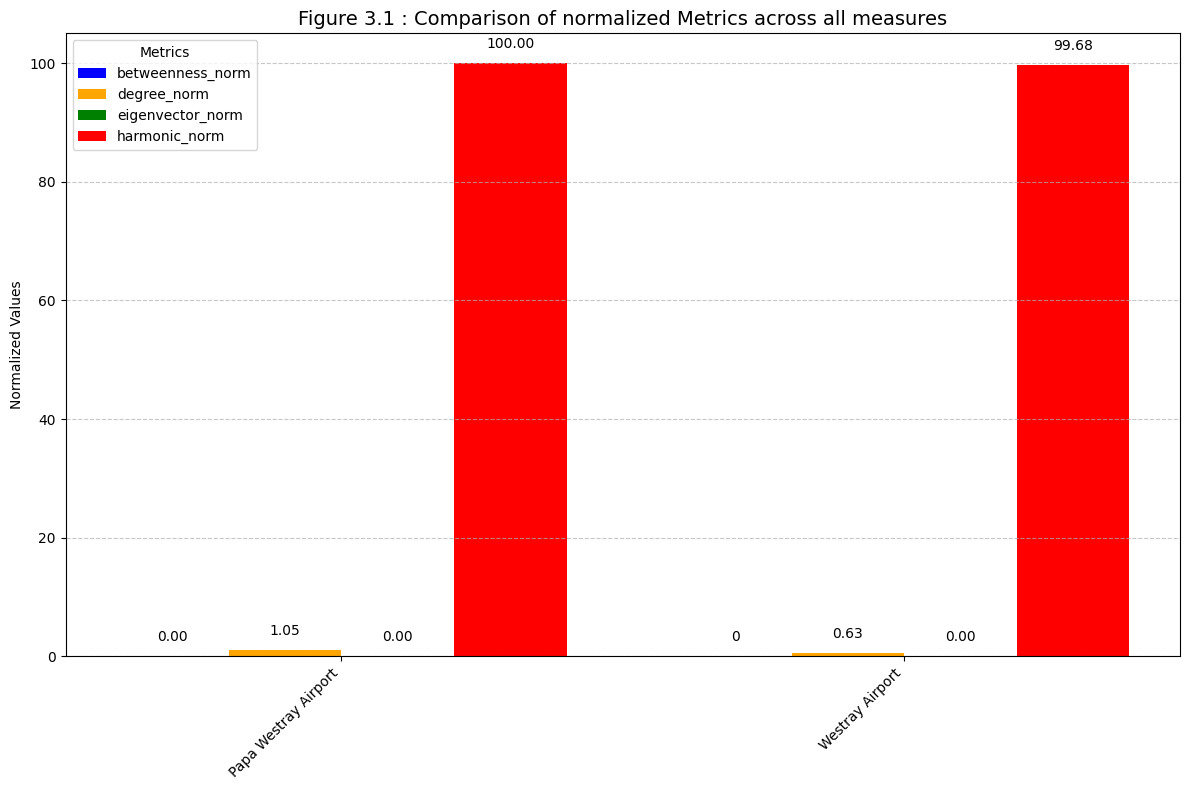

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Creating the data for  outliers
data = {
    "name": ["Papa Westray Airport", "Westray Airport"],
    "country": ["United Kingdom", "United Kingdom"],
    "betweenness_norm": [0.000729, 0.000000],
    "degree_norm": [1.050420, 0.630252],
    "eigenvector_norm": [0.000004, 0.000004],
    "harmonic_norm": [100.00000, 99.68126]
}

# Creating a DataFrame
df_corrected = pd.DataFrame(data)

# Plotting the data
fig, ax = plt.subplots(figsize=(12, 8))
x_labels = df_corrected['name']

# Define colors for each metric
colors = {
    "betweenness_norm": "blue",
    "degree_norm": "orange",
    "eigenvector_norm": "green",
    "harmonic_norm": "red"
}

# Plot each normalized metric as a grouped bar chart
metrics = ["betweenness_norm", "degree_norm", "eigenvector_norm", "harmonic_norm"]
x = range(len(x_labels))
width = 0.2

for i, metric in enumerate(metrics):
    bars = ax.bar(
        [p + i * width for p in x],
        df_corrected[metric],
        width,
        label=metric,
        color=colors[metric]
    )
    # Add data labels
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 2,  # Slight offset above the bar
            f"{height:.2f}" if height > 0 else "0",
            ha="center",
            va="bottom",
            fontsize=10
        )

# Formatting the chart
ax.set_xticks([p + width * (len(metrics) / 2 - 0.5) for p in x])
ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)
ax.set_ylabel("Normalized Values")
ax.set_title("Figure 3.1 : Comparison of normalized Metrics across all measures", fontsize=14)
ax.legend(title="Metrics", fontsize=10)
ax.grid(axis="y", linestyle="--", alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [26]:
missing_src = set(edges_df["src_index"]) - set(nodes_df["node_index"])
missing_trg = set(edges_df["trg_index"]) - set(nodes_df["node_index"])
print("Missing source indices:", missing_src)
print("Missing target indices:", missing_trg)


Missing source indices: set()
Missing target indices: set()


In [27]:
print("Number of nodes in G:", G.number_of_nodes())
print("Number of edges in G:", G.number_of_edges())


Number of nodes in G: 3214
Number of edges in G: 36907


In [28]:
import random

random_idx = random.randint(0, len(nodes_df)-1)
csv_node_id = nodes_df.loc[random_idx, "node_index"]
csv_name = nodes_df.loc[random_idx, "name"]

print("CSV says node_index =", csv_node_id, ", name =", csv_name)
print("Graph says G.nodes[node_index]['name'] =", G.nodes[csv_node_id]["name"])


CSV says node_index = 2906 , name = Anadolu Airport
Graph says G.nodes[node_index]['name'] = Anadolu Airport


In [29]:
import pandas as pd
import networkx as nx

# --- Create a tiny nodes_df ---
nodes_data = {
    "node_index": [0, 1, 2, 3],
    "openflights_id": [10, 11, 12, 13],
    "name": ["A", "B", "C", "D"],
    "city": ["CityA", "CityB", "CityC", "CityD"],
    "country": ["CountryA", "CountryB", "CountryC", "CountryD"],
    "latitude": [0.0, 0.0, 0.0, 0.0],   # Just placeholders
    "longitude": [0.0, 0.0, 0.0, 0.0], # Just placeholders
}
nodes_df_small = pd.DataFrame(nodes_data)

# --- Create a tiny edges_df ---
# For a simple directed graph with some weights:
edges_data = {
    "src_index": [0, 0, 1, 2],
    "trg_index": [1, 2, 2, 3],
    "distance":  [1.0, 2.0, 2.0, 1.0],  # or any numeric "distance"
}
edges_df_small = pd.DataFrame(edges_data)

print("nodes_df_small:")
print(nodes_df_small)
print("\nedges_df_small:")
print(edges_df_small)

# --- Build the graph ---
Gsmall = nx.DiGraph()

for _, row in nodes_df_small.iterrows():
    Gsmall.add_node(
        row["node_index"],
        name=row["name"],
        city=row["city"],
        country=row["country"],
        latitude=row["latitude"],
        longitude=row["longitude"]
    )

for _, row in edges_df_small.iterrows():
    s = row["src_index"]
    t = row["trg_index"]
    dist = row["distance"]
    # Usually check if s and t in G, but we know they exist here:
    Gsmall.add_edge(s, t, weight=dist)

print("\nTiny Graph => #nodes:", Gsmall.number_of_nodes(), " #edges:", Gsmall.number_of_edges())

# --- Compute centralities (similar to your big code) ---
deg_c = nx.degree_centrality(Gsmall)
bet_c = nx.betweenness_centrality(Gsmall, weight='weight')
harm_c = nx.harmonic_centrality(Gsmall, distance='weight')
largest_wcc = max(nx.weakly_connected_components(Gsmall), key=len)
subG = Gsmall.subgraph(largest_wcc).to_undirected()
eig_sub = nx.eigenvector_centrality_numpy(subG, weight='weight')

eig_c = {}
for n in Gsmall.nodes():
    eig_c[n] = eig_sub[n] if n in eig_sub else 0

# --- Print out raw results ---
print("\nCentralities for tiny example:")
for n in sorted(Gsmall.nodes()):
    print(f"Node {n}, name={Gsmall.nodes[n]['name']}")
    print("   degree_c        =", round(deg_c[n], 4))
    print("   betweenness_c   =", round(bet_c[n], 4))
    print("   harmonic_c      =", round(harm_c[n], 4))
    print("   eigenvector_c   =", round(eig_c[n], 4))


nodes_df_small:
   node_index  openflights_id name   city   country  latitude  longitude
0           0              10    A  CityA  CountryA       0.0        0.0
1           1              11    B  CityB  CountryB       0.0        0.0
2           2              12    C  CityC  CountryC       0.0        0.0
3           3              13    D  CityD  CountryD       0.0        0.0

edges_df_small:
   src_index  trg_index  distance
0          0          1       1.0
1          0          2       2.0
2          1          2       2.0
3          2          3       1.0

Tiny Graph => #nodes: 4  #edges: 4

Centralities for tiny example:
Node 0, name=A
   degree_c        = 0.6667
   betweenness_c   = 0.0
   harmonic_c      = 0
   eigenvector_c   = 0.5211
Node 1, name=B
   degree_c        = 0.6667
   betweenness_c   = 0.0
   harmonic_c      = 1.0
   eigenvector_c   = 0.5211
Node 2, name=C
   degree_c        = 1.0
   betweenness_c   = 0.3333
   harmonic_c      = 1.0
   eigenvector_c   = 0.6498
Nod

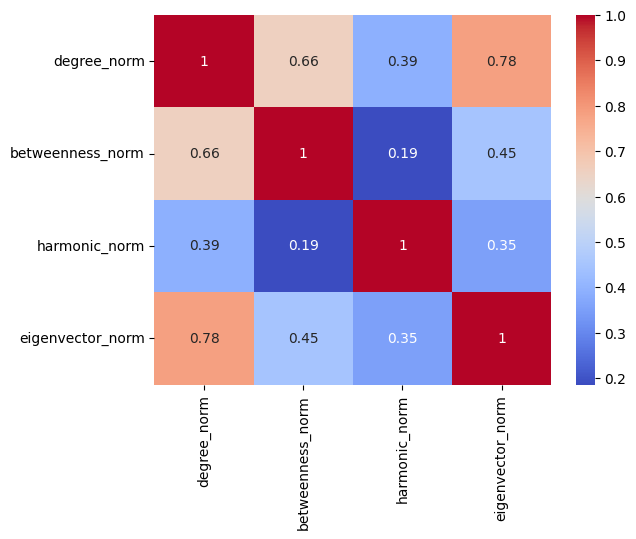

In [30]:
norm_cols = [m+"_norm" for m in ["degree","betweenness","harmonic","eigenvector"]]
corr_matrix = df_central[norm_cols].corr(method="spearman")
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()


In [31]:
def verify_top_10_airports_and_suspects(df_central, edges_df, graph,
                                        suspected_airports=None, top_k=15):
    """
    1) Prints out the top_k airports for each normalized measure (_norm).
       Shows node_index, name, measure value, in/out edges, and NetX Degree.
    2) Checks a list of suspected airports by partial name match, printing
       their actual measure values and rank to see if they're truly not in the top 10
       or if there's a data gap.

    df_central        : DataFrame with columns including node_index, name, city,
                        plus 'degree_norm', 'betweenness_norm', etc.
    edges_df          : DataFrame listing edges (src_index, trg_index)
    graph (networkx)  : The DiGraph used for centrality computations
    suspected_airports: e.g. ["Heathrow", "Haneda", "Sydney", "LHR", "PEK", "Papa Westray"]
    top_k             : How many airports to list in each measure's top 10.
    """

    # Identify which columns are the normalized measures
    measure_cols = [col for col in df_central.columns if col.endswith("_norm")]

    # Part 1: Show top_k airports for each centrality measure
    for measure in measure_cols:
        print(f"\n=== Top {top_k} by {measure} ===")
        # Grab the top_k rows
        top_df = df_central.nlargest(top_k, measure)

        for _, row in top_df.iterrows():
            idx = row["node_index"]
            nm  = row["name"]
            val = row[measure]

            out_edges = edges_df[edges_df["src_index"] == idx].shape[0]
            in_edges  = edges_df[edges_df["trg_index"] == idx].shape[0]
            netx_deg  = graph.degree(idx) if idx in graph else -1

            print(f"  Node {idx} | {nm} | {measure}={val:.2f}")
            print(f"    Outgoing: {out_edges}, Incoming: {in_edges}, NetX Degree: {netx_deg}")
        print("-" * 60)

    # Part 2: Check “suspected hubs”
    if suspected_airports:
        print("\nCHECKING SUSPECTED HUBS...\n")
        for airport_str in suspected_airports:
            print(f"Looking for airports matching: {airport_str}")
            # Basic string match on name, city, or country
            mask = (
                df_central["name"].str.contains(airport_str, case=False, na=False) |
                df_central["city"].str.contains(airport_str, case=False, na=False) |
                df_central["country"].str.contains(airport_str, case=False, na=False)
            )
            matched = df_central[mask]

            if matched.empty:
                print(f"  No rows found for '{airport_str}'")
                print("-" * 60)
                continue

            for _, row in matched.iterrows():
                idx = row["node_index"]
                nm  = row["name"]
                city = row.get("city", "")
                print(f"  Node {idx} | {nm} | {city}")

                # Show measure and rank
                for meas in measure_cols:
                    val = row[meas]
                    # 1-based rank in descending order
                    rank = (df_central[meas] > val).sum() + 1
                    print(f"    {meas}: {val:.2f}   (Rank: {rank})")
            print("-" * 60)


# EXAMPLE USAGE:
verify_top_10_airports_and_suspects(
    df_central=df_central,
    edges_df=edges_df,
    graph=G,
    suspected_airports=["Heathrow","John F Kennedy","Dubai", "PEK", "Papa Westray","Frankurt"],
    top_k=15
)


=== Top 15 by degree_norm ===
  Node 191 | Frankfurt am Main Airport | degree_norm=100.00
    Outgoing: 497, Incoming: 493, NetX Degree: 477
  Node 628 | Charles de Gaulle International Airport | degree_norm=98.53
    Outgoing: 524, Incoming: 517, NetX Degree: 470
  Node 282 | Amsterdam Airport Schiphol | degree_norm=97.06
    Outgoing: 453, Incoming: 450, NetX Degree: 463
  Node 770 | Atatürk International Airport | degree_norm=94.54
    Outgoing: 354, Incoming: 357, NetX Degree: 451
  Node 1809 | Hartsfield Jackson Atlanta International Airport | degree_norm=90.76
    Outgoing: 915, Incoming: 911, NetX Degree: 433
  Node 1885 | Chicago O'Hare International Airport | degree_norm=85.71
    Outgoing: 558, Incoming: 550, NetX Degree: 409
  Node 1642 | Beijing Capital International Airport | degree_norm=85.50
    Outgoing: 531, Incoming: 530, NetX Degree: 408
  Node 196 | Munich Airport | degree_norm=79.62
    Outgoing: 368, Incoming: 360, NetX Degree: 380
  Node 2016 | Domodedovo Intern

In [33]:
import pandas as pd
import math

# Define the haversine function to compute great‐circle distances (in kilometers)
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great‐circle distance between two points on the Earth
    using the haversine formula.

    Parameters:
        lat1, lon1 : Latitude and Longitude of point 1 (in decimal degrees).
        lat2, lon2 : Latitude and Longitude of point 2 (in decimal degrees).

    Returns:
        Distance in kilometers.
    """
    R = 6371.0  # Mean Earth radius in kilometers (Sinnott, 1984)
    # Convert decimal degrees to radians
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

# Load the OpenFlights dataset (nodes.csv) containing airport data.
nodes_df = pd.read_csv("nodes.csv")

# Clean up column names: remove extra spaces, leading '#' characters, and convert to lowercase.
nodes_df.columns = nodes_df.columns.str.strip().str.replace(r"^#\s*", "", regex=True).str.lower()

# Use the column 'name' for airport names.
name_col = "name"

# Filter the DataFrame for the relevant Orkney Islands airports.
# Using regex to precisely match "Papa Westray" and "Westray" separately.
kirkwall = nodes_df[nodes_df[name_col].str.contains("Kirkwall", case=False, na=False)].iloc[0]
papa_westray = nodes_df[nodes_df[name_col].str.match("(?i)^Papa Westray")].iloc[0]
westray = nodes_df[(nodes_df[name_col].str.match("(?i)^Westray")) &
                   (~nodes_df[name_col].str.contains("Papa", case=False, na=False))].iloc[0]
sanday = nodes_df[nodes_df[name_col].str.contains("Sanday", case=False, na=False)].iloc[0]
stronsay = nodes_df[nodes_df[name_col].str.contains("Stronsay", case=False, na=False)].iloc[0]


# Compute distances between Kirkwall and each neighboring airport using the haversine function.
d_kirkwall_papa = haversine(kirkwall['latitude'], kirkwall['longitude'],
                            papa_westray['latitude'], papa_westray['longitude'])
d_kirkwall_westray = haversine(kirkwall['latitude'], kirkwall['longitude'],
                               westray['latitude'], westray['longitude'])
d_kirkwall_sanday = haversine(kirkwall['latitude'], kirkwall['longitude'],
                              sanday['latitude'], sanday['longitude'])
d_kirkwall_stronsay = haversine(kirkwall['latitude'], kirkwall['longitude'],
                                stronsay['latitude'], stronsay['longitude'])

# Compute the distance between Papa Westray and Westray using the dataset coordinates.
d_papa_westray_westray = haversine(papa_westray['latitude'], papa_westray['longitude'],
                                   westray['latitude'], westray['longitude'])

# Print the computed distances.
print(f"Kirkwall → Papa Westray: {d_kirkwall_papa:.1f} km")
print(f"Kirkwall → Westray: {d_kirkwall_westray:.1f} km")
print(f"Kirkwall → Sanday: {d_kirkwall_sanday:.1f} km")
print(f"Kirkwall → Stronsay: {d_kirkwall_stronsay:.1f} km")
print(f"Papa Westray → Westray: {d_papa_westray_westray:.1f} km")

Kirkwall → Papa Westray: 43.8 km
Kirkwall → Westray: 43.7 km
Kirkwall → Sanday: 37.5 km
Kirkwall → Stronsay: 26.6 km
Papa Westray → Westray: 2.8 km


In [34]:
import pandas as pd
import math

# Define the haversine function to compute great‐circle distances (in kilometers)
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great‐circle distance between two points on the Earth
    using the haversine formula.

    Parameters:
        lat1, lon1 : Latitude and Longitude of point 1 (in decimal degrees).
        lat2, lon2 : Latitude and Longitude of point 2 (in decimal degrees).

    Returns:
        Distance in kilometers.
    """
    R = 6371.0  # Mean Earth radius in kilometers (Sinnott, 1984)
    # Convert decimal degrees to radians
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.asin(math.sqrt(a))
    return R * c

# Load the OpenFlights dataset (nodes.csv) containing airport data.
nodes_df = pd.read_csv("nodes.csv")

# Clean up column names: remove extra spaces, leading '#' characters, and convert to lowercase.
nodes_df.columns = nodes_df.columns.str.strip().str.replace(r"^#\s*", "", regex=True).str.lower()

# Use the column 'name' for airport names.
name_col = "name"

# Filter the DataFrame for the relevant Orkney Islands airports.
# Use regex to precisely match "Papa Westray" and "Westray" separately.
kirkwall = nodes_df[nodes_df[name_col].str.contains("Kirkwall", case=False, na=False)].iloc[0]
papa_westray = nodes_df[nodes_df[name_col].str.match("(?i)^Papa Westray")].iloc[0]
westray = nodes_df[(nodes_df[name_col].str.match("(?i)^Westray")) &
                   (~nodes_df[name_col].str.contains("Papa", case=False, na=False))].iloc[0]
sanday = nodes_df[nodes_df[name_col].str.contains("Sanday", case=False, na=False)].iloc[0]
stronsay = nodes_df[nodes_df[name_col].str.contains("Stronsay", case=False, na=False)].iloc[0]


# Compute distances between Kirkwall and each neighboring airport using the haversine function.
d_kirkwall_papa = haversine(kirkwall['latitude'], kirkwall['longitude'],
                            papa_westray['latitude'], papa_westray['longitude'])
d_kirkwall_westray = haversine(kirkwall['latitude'], kirkwall['longitude'],
                               westray['latitude'], westray['longitude'])
d_kirkwall_sanday = haversine(kirkwall['latitude'], kirkwall['longitude'],
                              sanday['latitude'], sanday['longitude'])
d_kirkwall_stronsay = haversine(kirkwall['latitude'], kirkwall['longitude'],
                                stronsay['latitude'], stronsay['longitude'])

# Compute the distance between Papa Westray and Westray using the dataset's coordinates.
d_papa_westray_westray = haversine(papa_westray['latitude'], papa_westray['longitude'],
                                   westray['latitude'], westray['longitude'])

# Additionally, compute distances from Papa Westray to Sanday and to Stronsay.
d_papa_westray_sanday = haversine(papa_westray['latitude'], papa_westray['longitude'],
                                  sanday['latitude'], sanday['longitude'])
d_papa_westray_stronsay = haversine(papa_westray['latitude'], papa_westray['longitude'],
                                    stronsay['latitude'], stronsay['longitude'])

# Print the computed distances.
print(f"Kirkwall → Papa Westray: {d_kirkwall_papa:.1f} km")
print(f"Kirkwall → Westray: {d_kirkwall_westray:.1f} km")
print(f"Kirkwall → Sanday: {d_kirkwall_sanday:.1f} km")
print(f"Kirkwall → Stronsay: {d_kirkwall_stronsay:.1f} km")
print(f"Papa Westray → Westray: {d_papa_westray_westray:.1f} km")
print(f"Papa Westray → Sanday: {d_papa_westray_sanday:.1f} km")
print(f"Papa Westray → Stronsay: {d_papa_westray_stronsay:.1f} km")

Kirkwall → Papa Westray: 43.8 km
Kirkwall → Westray: 43.7 km
Kirkwall → Sanday: 37.5 km
Kirkwall → Stronsay: 26.6 km
Papa Westray → Westray: 2.8 km
Papa Westray → Sanday: 21.6 km
Papa Westray → Stronsay: 26.3 km
